# Atlas notebooks

***

> This notebook reproduces and extends parts of the regional figures of the AR6-WGI Atlas chapter. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes.

## Selecting reference regions used for every CORDEX domain


12/07/2021

**J. Diez-Sierra** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

For the different CORDEX domains, aggregated results are calculated only in those reference regions (Iturbide et al. 2020) with overlap larger than 80%. Reference overlapped regions resulting for every CORDEX domain are calculated with the present script. Regular geographic grids for every CORDEX domain are obtained from Table 2 in the CORDEX specification archive: [cordex_archive_specification.pdf](https://is-enes-data.github.io/cordex_archive_specifications.pdf) 

### Load packages

This script requires regionmask version 0.6.1 or later and xarray version 0.15.1 or later. Check the documentation of regionmask for details.

In [2]:
import regionmask
import xarray as xr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Loading the reference regions

The regions are available at regionmask.defined_regions.ar6. The whole set of 58 regions is available under (ar6.all). In addition the land (ar6.land) and ocean (ar6.ocean) regions are given separately. The numbering is kept consistent between the categories. Note that some regions are in the land and in the ocean categories (e.g. the Mediterranean).

In [3]:
ar6_all = regionmask.defined_regions.ar6.all
ar6_all

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

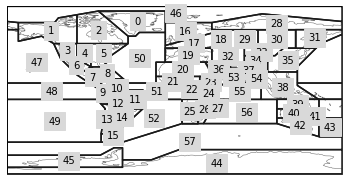

In [4]:
ax = ar6_all.plot()

### Loading reference grids (0.5 degree)

Global longitude and latitude, at the same resoluction as aggregated results for CORDEX domain (0.5 degree), is obtained from the WFDE5 dataset in order to compare the total area covered for every reference region with those overlapped with each CORDEX domains. 

Bellow we calculate the number of grid boxes that fall in every reference regions. We use cos(lat) as proxy of the grid area. This works well for the rectangular grid in our example. In general, it is better to the model's own grid area.

In [5]:
ds = xr.open_dataset("../reference-grids/land_sea_mask_05degree.nc4")
XX_WORLD, YY_WORLD = np.meshgrid(ds.lon, ds.lat)
mask_2d_WORLD = ar6_all.mask(ds.lon, ds.lat)
weights_WORLD = np.cos(np.deg2rad(YY_WORLD))
ds.close()

### Defining CORDEX domains 
Regular geographic grids for every CORDEX domain are obtained from Table 2 in the CORDEX specification archive https://is-enes-data.github.io/cordex_archive_specifications.pdf. Note that CORDEX corner definition can present some differences among simulations. Note also that native rotated-pole projections occupy a smaller area than regular grids.

In [6]:
regular_CORDEX_grids = pd.read_csv('auxiliary-material/regular-CORDEX-grids.csv', index_col = 1)

In [7]:
regular_CORDEX_grids

,Area,deg,Nlon,Nlat,West,East,South,North
Name,,,,,,,,
NAM-44i,North America,0.500,300,129,-171.7500,-22.2500,12.2500,76.2500
CAM-44i,Central America,0.500,207,111,-124.7500,-21.7500,-19.7500,35.2500
SAM-44i,South America,0.500,181,155,-106.2500,-16.2500,-58.2500,18.7500
ARC-44i,Arctic,0.500,720,83,-179.7500,179.7500,48.7500,89.7500
AFR-44i,Africa,0.500,173,179,-25.2500,60.7500,-46.2500,42.7500
EUR-44i,Europe,0.500,221,103,-44.7500,65.2500,21.7500,72.7500
MED-44i,Mediterranean,0.500,144,65,-20.7500,51.7500,25.2500,57.2500
MNA-44i,Middle East and North Africa,0.500,206,106,-26.7500,75.7500,-7.2500,45.2500
EAS-44i,East Asia,0.500,227,157,62.7500,175.7500,-18.7500,59.2500


Selecting CORDEX domains

In [8]:
CORDEX_doms = ['NAM-44i','CAM-44i','SAM-44i','ARC-44i','AFR-44i','EUR-44i','MED-44i',
                  'MNA-44i','SEA-22i','EAS-44i','WAS-44i','CAS-44i','ANT-44i','AUS-44i'] 

### Calculating overlaps

Empty dataframe to add the results

In [9]:
Overlaps_CORDEX_ReferenceRegions = pd.DataFrame(index = CORDEX_doms, columns = np.arange(len(ar6_all)))# Percetaje of overlapped area

Overlap calculation comparing the number of cells that fall inside every reference region, using the coordinates lon and lat from the file land_sea_mask_05degree.nc4, with those that fall inside the regular grid for every CORDEX domain.

In [10]:
for dom in CORDEX_doms:
    lon = np.arange(regular_CORDEX_grids.loc[dom]['West'], regular_CORDEX_grids.loc[dom]['East']+0.5, 0.5)
    lat = np.arange(regular_CORDEX_grids.loc[dom]['South'], regular_CORDEX_grids.loc[dom]['North']+0.5, 0.5)
    XX, YY = np.meshgrid(lon, lat)
    mask_2d_domain = ar6_all.mask(lon, lat)
    weights_domain = np.cos(np.deg2rad(YY))
    for reg in np.unique(mask_2d_domain.values):
        if not np.isnan(reg):
            pos = np.where(mask_2d_domain.values == reg)
            pos_w = np.where(mask_2d_WORLD.values == reg)
            Overlaps_CORDEX_ReferenceRegions[reg].loc[dom] = np.round(100*np.sum(np.ones_like(pos[0])*weights_domain[pos])/np.sum(np.ones_like(pos_w[0])*weights_WORLD[pos_w]), 2)

Set the name for the reference regions, convert nan to 0 and transpose matrix

In [11]:
abbr_reg = []
for n in Overlaps_CORDEX_ReferenceRegions.columns:
    abbr_reg.append(ar6_all.regions[n].abbrev)
Overlaps_CORDEX_ReferenceRegions.columns = abbr_reg
Overlaps_CORDEX_ReferenceRegions = Overlaps_CORDEX_ReferenceRegions.fillna(0)
Overlaps_CORDEX_ReferenceRegions = Overlaps_CORDEX_ReferenceRegions.transpose()

Overlap results (%)

In [12]:
Overlaps_CORDEX_ReferenceRegions

,NAM-44i,CAM-44i,SAM-44i,ARC-44i,AFR-44i,EUR-44i,MED-44i,MNA-44i,SEA-22i,EAS-44i,WAS-44i,CAS-44i,ANT-44i,AUS-44i
GIC,60.45,0.00,0.00,100.00,0.00,41.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NWN,98.06,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NEN,94.44,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
WNA,100.00,8.77,0.00,9.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CNA,100.00,32.76,0.00,6.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENA,100.00,32.30,0.00,8.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NCA,100.00,100.00,4.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SCA,63.87,100.00,85.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CAR,100.00,100.00,54.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NWS,0.00,100.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Selecting those reference regions that overlap larger than 80% for every CORDEX domain 

Select those regions that overlap larger than 80%

In [13]:
threshold = 80

In [14]:
for dom in Overlaps_CORDEX_ReferenceRegions.transpose().index:
    AR6_dom = Overlaps_CORDEX_ReferenceRegions.transpose().loc[dom][Overlaps_CORDEX_ReferenceRegions.transpose().loc[dom]>80].index    
    print(dom + ":" + str(AR6_dom.tolist()))

NAM-44i:['NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'CAR']
CAM-44i:['NCA', 'SCA', 'CAR', 'NWS', 'NSA', 'NES', 'SAM']
SAM-44i:['SCA', 'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA']
ARC-44i:['GIC', 'NWN', 'NEN', 'NEU', 'RAR', 'RFE', 'ARO']
AFR-44i:['MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'ARP']
EUR-44i:['NEU', 'WCE', 'EEU', 'MED']
MED-44i:['WCE', 'MED']
MNA-44i:['MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WCA', 'ARP', 'ARS']
SEA-22i:['SEA']
EAS-44i:['ECA', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'BOB']
WAS-44i:['NEAF', 'SEAF', 'WCA', 'ECA', 'TIB', 'ARP', 'SAS', 'ARS', 'BOB', 'EIO']
CAS-44i:['EEU', 'WSB', 'ESB', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP']
ANT-44i:['EAN', 'WAN']
AUS-44i:['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ']


### Session info

In [15]:
!conda list

# packages in environment at /home/javi/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
_libgcc_mutex             0.1                        main  
alabaster                 0.7.12                     py_0  
anaconda                  2020.11                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        1.10.0                   py38_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38h7b6447c_1  
asn1crypto                1.4.0                      py_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.2            py38h7b6447c_0  
async_generator           1.10                       py_0  
atomicwrites              1.4.0                      py_0  
attrs                     20.3.0        